# model 2

In [1]:
# Run development environment checks for gpu compute
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Is built with CUDA:", tf.test.is_built_with_cuda())
print("GPUs detected:", tf.config.list_physical_devices('GPU'))

2025-07-18 00:50:49.623094: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752799849.655675  266053 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752799849.666202  266053 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752799849.689956  266053 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752799849.689999  266053 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752799849.690007  266053 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
Is built with CUDA: True
GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Run these dependency checks if pixi gets buggy
#!pip install transformers

In [ ]:
#!pip install datasets

In [ ]:
#!pip install tf-keras

In [ ]:
#!pip install --upgrade pillow

In [5]:
#!rm -rf ~/.cache/huggingface

In [6]:
#!rm -rf ~/.keras

In [7]:
#!rm -rf ~/.cache/huggingface/datasets

In [11]:
import os
import random
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, GPT2Tokenizer
import datasets
from datasets import load_dataset

# GPT-2 Classifier
model = TFAutoModelForSequenceClassification.from_pretrained("gpt2", num_labels=1)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id
model._name = "model_2"

# Load dataset
"""
The backend for HF datasets format datasets a certain way. For dataset configs set these configs as needed
"""
#dataset_dict = load_dataset("deepcopy/MathWriting-human", trust_remote_code=True)
#dataset_dict = dataset_dict.cast_column("image", datasets.Image(decode=False))
dataset_dict = load_dataset("deepcopy/MathWriting-human")

# Set this config for percentage of the data
USE_PERCENTAGE = 0.10
train_samples = int(USE_PERCENTAGE * len(dataset_dict["train"]))
val_samples = int(USE_PERCENTAGE * len(dataset_dict["val"]))

train_small = dataset_dict["train"].select(range(train_samples))
val_small = dataset_dict["val"].select(range(val_samples))

# Add binary_label
latex_pool = train_small["latex"]

def add_binary_label(example):
    if random.random() > 0.5:
        example["binary_label"] = 1
        example["latex_used"] = example["latex"]
    else:
        wrong_latex = random.choice(latex_pool)
        while wrong_latex == example["latex"]:
            wrong_latex = random.choice(latex_pool)
        example["binary_label"] = 0
        example["latex_used"] = wrong_latex
    return example

train_small = train_small.map(add_binary_label)
val_small = val_small.map(add_binary_label)

def encode_example(example):
    encoded = tokenizer(
        example["latex_used"],
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="tf"
    )
    return {
        "input_ids": encoded["input_ids"][0],
        "attention_mask": encoded["attention_mask"][0],
        "label": tf.cast(example["binary_label"], tf.float32)
    }

def hf_to_tf_dataset(hf_dataset, batch_size=8):
    def gen():
        for example in hf_dataset:
            encoded = encode_example(example)
            yield ({
                "input_ids": encoded["input_ids"],
                "attention_mask": encoded["attention_mask"]
            }, encoded["label"])

    output_signature = (
        {
            "input_ids": tf.TensorSpec(shape=(128,), dtype=tf.int32),
            "attention_mask": tf.TensorSpec(shape=(128,), dtype=tf.int32)
        },
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )

    return tf.data.Dataset.from_generator(gen, output_signature=output_signature)\
             .shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)

tf_train = hf_to_tf_dataset(train_small)
tf_val = hf_to_tf_dataset(val_small)

# Compile GPT-2 model for classification
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metric_fn = tf.keras.metrics.BinaryAccuracy()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=loss_fn,
    metrics=[metric_fn],
    #run_eagerly=True # TODO: research
)

# Train
history = model.fit(
    tf_train,
    validation_data=tf_val,
    epochs=5,
    verbose=1
)

All PyTorch model weights were used when initializing TFGPT2ForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFGPT2ForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
   2874/Unknown - 254s 71ms/step - loss: 0.7106 - binary_accuracy: 0.5031

2025-07-18 01:21:23.899730: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11808238500698005727
2025-07-18 01:21:23.899773: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 14823544778033205941
2025-07-18 01:21:23.899786: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 2271771499802206857
2025-07-18 01:21:23.899795: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 9004410496730667563
2025-07-18 01:21:23.900331: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[model_2/transformer/Shape_1/_10]]
2025-07-18 01:21:37.216696: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9348583251139726807
2025-07-18 01:21:37.216741: I t

2874/2874 [==============================] - 268s 76ms/step - loss: 0.7106 - binary_accuracy: 0.5031 - val_loss: 0.7166 - val_binary_accuracy: 0.4780
Epoch 2/5
2874/2874 [==============================] - 204s 71ms/step - loss: 0.6966 - binary_accuracy: 0.5046 - val_loss: 0.7093 - val_binary_accuracy: 0.4780
Epoch 3/5
2874/2874 [==============================] - 187s 65ms/step - loss: 0.6955 - binary_accuracy: 0.5037 - val_loss: 0.7083 - val_binary_accuracy: 0.4780
Epoch 4/5
2874/2874 [==============================] - 192s 67ms/step - loss: 0.6949 - binary_accuracy: 0.5037 - val_loss: 0.7136 - val_binary_accuracy: 0.4684
Epoch 5/5
2874/2874 [==============================] - 181s 63ms/step - loss: 0.6940 - binary_accuracy: 0.5038 - val_loss: 0.6980 - val_binary_accuracy: 0.4780


In [12]:
# Model summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 score (Dense)               multiple                  768       
                                                                 
 transformer (TFGPT2MainLay  multiple                  124439808 
 er)                                                             
                                                                 
Total params: 124440576 (474.70 MB)
Trainable params: 124440576 (474.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


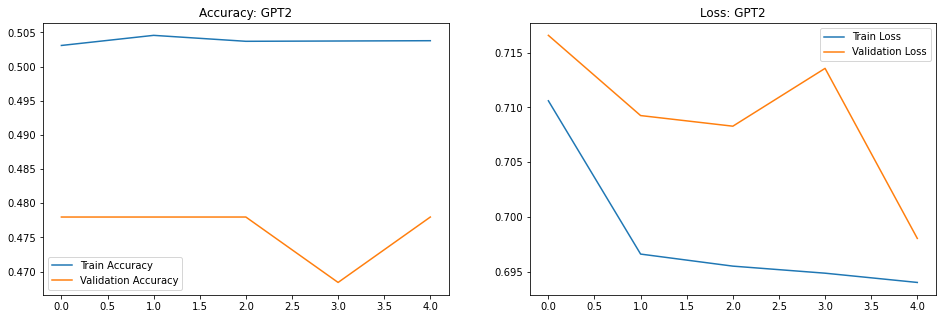

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy: GPT2')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss: GPT2')

plt.show()

In [17]:
y_true = []
y_pred = []

for batch in tf_val:
    inputs, labels = batch
    logits = model.predict(inputs, verbose=0).logits
    predictions = tf.sigmoid(logits).numpy().flatten()
    predicted_labels = (predictions > 0.5).astype(int)
    
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)

In [18]:
from sklearn.metrics import f1_score

f1 = f1_score(y_true, y_pred)
print("F1 Score:", round(f1, 4))

F1 Score: 0.0456


              precision    recall  f1-score   support

           0     0.4708    0.9479    0.6292       749
           1     0.3390    0.0244    0.0456       818

    accuracy                         0.4659      1567
   macro avg     0.4049    0.4862    0.3374      1567
weighted avg     0.4020    0.4659    0.3245      1567



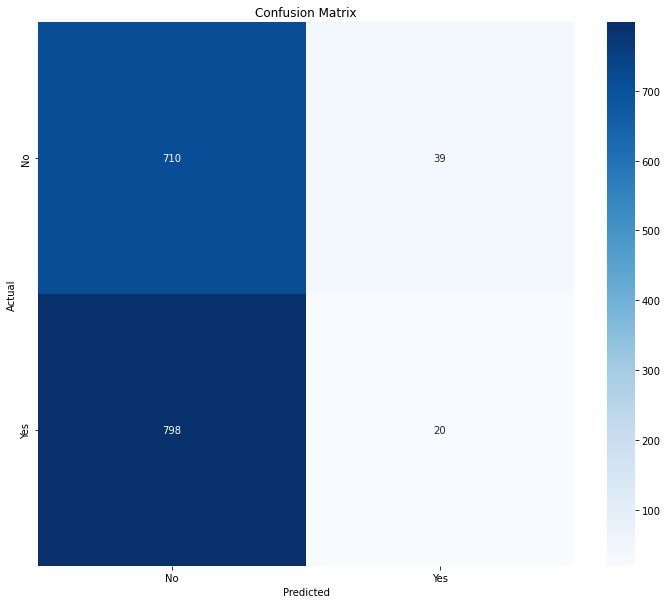

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Print full report
print(classification_report(y_true, y_pred, digits=4))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [24]:
# Save builds
model.save_weights("model2_weights.h5")
model.save("models/model2_savedmodel", save_format="tf")
model.save_pretrained("models/model2.h5")
model.save_pretrained("models/model2.keras")
tokenizer.save_pretrained("models/model2.h5")
tokenizer.save_pretrained("models/model2.keras")

# Loading legacy model weights
# Example usage:
#model.load_weights("model2_weights.h5")

INFO:tensorflow:Assets written to: models/model2_savedmodel/assets


INFO:tensorflow:Assets written to: models/model2_savedmodel/assets


('models/model2.keras/tokenizer_config.json',
 'models/model2.keras/special_tokens_map.json',
 'models/model2.keras/vocab.json',
 'models/model2.keras/merges.txt',
 'models/model2.keras/added_tokens.json')

GPT2 took a bit to run. The results show how rigorous math is as a field. Further research and work is needed.

In [ ]:
# end of Model 2 build and test runs